This notebook contains the following:

1)	Importing relevant libraries and dataset.

2)	Creating a time variable => checking the duration of trips.

3)	Subsetting to look for patterns. 

4)	Dealing with negative values for new time variable.

5)	Checking correlation between duration of trip (in minutes) and fare to pay.

6)	Patterns on the duration of trips. Creating a line chart.

7)	Getting summary stats for correlation.

8)	Exporting file to folder. Creating and saving new variables in original data set.


In [1]:
# Importing Analitycal and Visual libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import datetime 
import folium
import json
import plotly
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans 
import pylab as pl 

In [2]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

Creating a path to import and working on data set

In [3]:
# Establishing path
path = r'C:\Users\Paola\Desktop\Shaul\Data\CF\Data Immersion\Achievement 6\Uber October-2023 Basket Analysis'

In [4]:
# Following observations from previous notebooks, trip fare has been limited to $15 in order not to skew the data.

df = pd.read_csv(os.path.join(path, '2-Data', 'Prepared Data', 'uber_usd15_trips.csv'), index_col = False)

Creating a time variable (minutes) to get the duration of trips in time.

In [16]:
# I am splitting the 'pickup time new' column into 3 columns: hours, minutes and seconds.
# I want to subtract the number of minutes between drop off and pickup times, to check if this affects the price.
df[['h','m','s']] = df['pickup_time_new'].astype(str).str.split(':', expand=True).astype(int)

In [17]:
# Dropping the unnecessary columns.
df = df.drop(columns=['s'])

In [18]:
# Renaming the hour-variable column for easier identification
df.rename(columns = {'h' : 'pickup hour'}, inplace = True)

In [19]:
# Renaming the minute-variable column for easier identification
df.rename(columns = {'m' : 'pickup'}, inplace = True)

In [20]:
# I am splitting the 'dropoff time new' column into 3 columns: hours, minutes and seconds.
# I want to subtract the number of minutes between drop off and pickup times, to check if this affects the price.
df[['h','m','s']] = df['dropoff_time_new'].astype(str).str.split(':', expand=True).astype(int)

In [21]:
# Dropping the unnecessary columns.
df = df.drop(columns=['h','s'])

In [22]:
# Renaming the time-variable column for easier identification
df.rename(columns = {'m' : 'dropoff'}, inplace = True)

In [23]:
df.columns

Index(['VendorID', 'pickup_date', 'pickup_time', 'dropoff_date',
       'dropoff_time', 'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'Trip category',
       'Fare category', 'pickup_time_new', 'dropoff_time_new',
       'pickup_date_new', 'dropoff_date_new', 'geometry', 'Borough_name',
       'payment_category', 'pickup hour', 'pickup time', 'dropoff time',
       'time trip', 'pickup hour', 'pickup time', 'dropoff time',
       'pickup hour', 'pickup', 'dropoff'],
      dtype='object')

In [25]:
df['time trip'] = df['dropoff'] - df['pickup']

In [28]:
df = df.loc[:,~df.columns.duplicated()].copy()

In [29]:
df.columns

Index(['VendorID', 'pickup_date', 'pickup_time', 'dropoff_date',
       'dropoff_time', 'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'Trip category',
       'Fare category', 'pickup_time_new', 'dropoff_time_new',
       'pickup_date_new', 'dropoff_date_new', 'geometry', 'Borough_name',
       'payment_category', 'pickup hour', 'pickup time', 'dropoff time',
       'time trip', 'pickup', 'dropoff'],
      dtype='object')

In [30]:
df.shape

(74551, 36)

Creating a subset to look for patterns

In [31]:
sub = df[['time trip', 'fare_amount']]

In [32]:
sub.describe()

,time trip,fare_amount
count,74551.000000,74551.000000
mean,0.429585,8.449496
std,21.138156,3.047291
min,-59.000000,0.000000
25%,4.000000,6.000000
50%,7.000000,8.000000
75%,12.000000,10.500000
max,58.000000,15.000000


In [33]:
sub.loc[sub['time trip'] < 0]

,time trip,fare_amount
1686,-9,11.0
1794,-20,5.0
3458,-33,5.5
4084,-13,10.0
4199,-38,14.0
...,...,...
72311,-8,7.5
73637,-3,6.0
73653,-22,13.5
74095,-25,5.5


There are 11656 rows in which the duration of the trip in time has a negative value. This does not make sense. An initial correlation test on this data showed no causal relation between duration of trip in time and increase in fare.

I will replace the negative values with the median and check if the results change.
This is not an easy decision, and I would have checked this with my superior. This negative values represent about 15% of the total data, which is very significant from a statistical perspective. However, by replacing these missing values with the median, I can now see a pattern emerging from the data. I do not think that the median value in this proportion (15%) would have made such an impact. However, the negative values certainly did.

Dealing with new negative values for time variable.

In [34]:
# Replacing  negative outliers with the mean. 
sub.loc[df['time trip'] < 0, 'time trip'] = np.nan

In [35]:
# Negative outliers solved => same operation repeated for all columns just named above.
sub['time trip'].fillna((df['time trip'].median()), inplace=True)

C:\Users\Paola\AppData\Local\Temp\ipykernel_13820\2059368893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['time trip'].fillna((df['time trip'].median()), inplace=True)


In [36]:
# Checking stats after replacing the negative values with the mean.
sub.describe()

,time trip,fare_amount
count,74551.000000,74551.000000
mean,8.897426,8.449496
std,4.666666,3.047291
min,0.000000,0.000000
25%,6.000000,6.000000
50%,7.000000,8.000000
75%,12.000000,10.500000
max,58.000000,15.000000


Checking correlation between duration of trip (in minutes) and fare to pay.

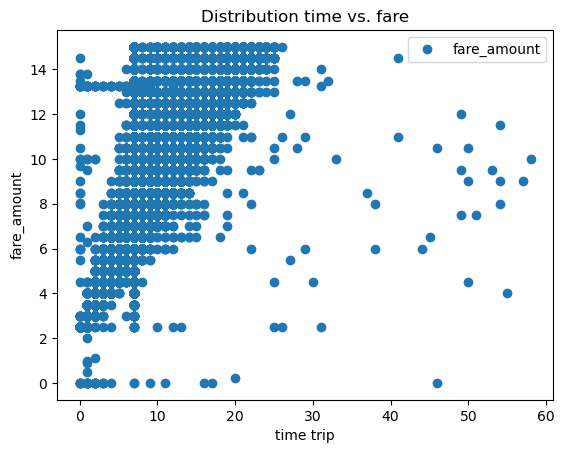

In [37]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

sub.plot(x = 'time trip', y='fare_amount',style='o') 
plt.title('Distribution time vs. fare')  
plt.xlabel('time trip')  
plt.ylabel('fare_amount')  
plt.show()
# Visualisation saved using right click, to visualisation folder.

In [38]:
# There seems to be a clear pattern between length of trip (in time, NOT distance) and fare.
# I am now checking the correlation between these 2 variables (hour and fare).
# Reshaping the variables into NumPy arrays and putting them into separate objects.

X = sub['time trip'].values.reshape(-1,1)
y = sub['fare_amount'].values.reshape(-1,1)

In [39]:
# Checking the arrays
X

array([[ 7.],
       [11.],
       [ 5.],
       ...,
       [15.],
       [ 5.],
       [ 5.]])

In [40]:
y

array([[ 9. ],
       [11. ],
       [ 5.5],
       ...,
       [14. ],
       [ 5.5],
       [ 6. ]])

In [41]:
# Spliting the data into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
# Checking the X_train array
X_train

array([[ 6.],
       [ 7.],
       [ 7.],
       ...,
       [15.],
       [ 1.],
       [ 7.]])

In [43]:
# Creating a regression object.

reg = LinearRegression()

In [44]:
# Fitting the regression object onto the training set.

reg.fit(X_train, y_train)

LinearRegression()

In [45]:
# Predicting the values of y using X.

y_pred = reg.predict(X_test)

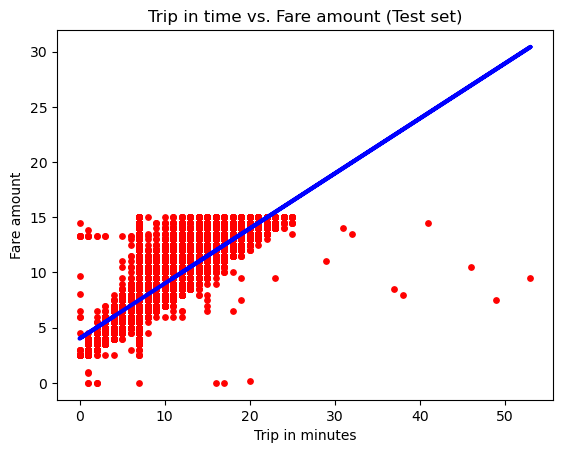

In [46]:
# Creating a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='red', s = 15)
plot_test.plot(X_test, y_pred, color='blue', linewidth =3)
plot_test.title('Trip in time vs. Fare amount (Test set)')
plot_test.xlabel('Trip in minutes')
plot_test.ylabel('Fare amount')
plot_test.show()
# Saving graph with right click.

In [47]:
sub.corr()

,time trip,fare_amount
time trip,1.000000,0.766223
fare_amount,0.766223,1.000000


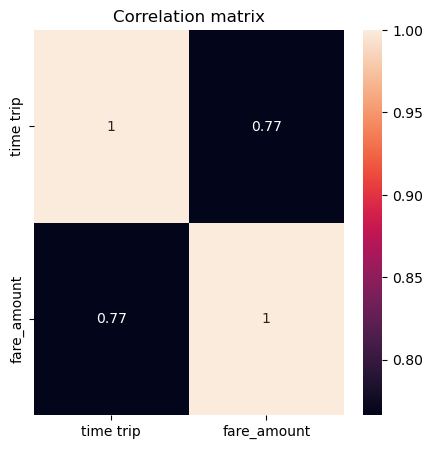

In [48]:
# Create a subplot with matplotlib
f,ax = plt.subplots(figsize=(5,5))

# Create the correlation heatmap in seaborn.
corr = sns.heatmap(sub.corr(), annot = True, ax = ax).set(title = 'Correlation matrix') 

Now that i have replaced the negative values for the median, the data shows a moderate to strong correlation between duration of trip in time and fare to pay

Patterns on the duration of trips. Creating a line chart.

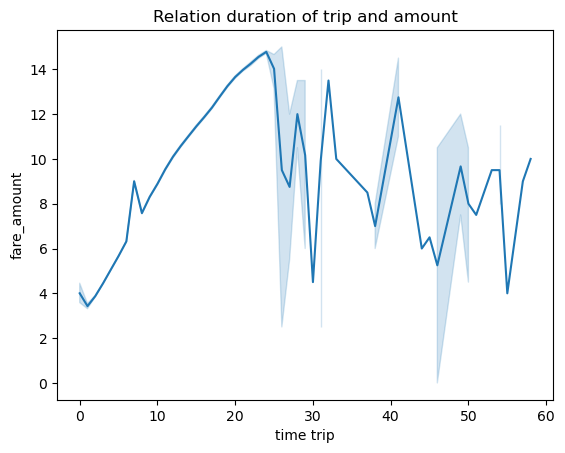

In [50]:
line2 = sns.lineplot(data = sub, x = 'time trip',y = 'fare_amount').set(title = 'Relation duration of trip and amount')

There is a clear pattern of increasing the trip's fare with the duration of the trip => when it is regarding short trips (up to 25 minutes).

In previous notebooks, I have shown that short trips are the most common in this dataset.

In [51]:
# Creating objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_pred) # This is the mean squared error
r2 = r2_score(y_test, y_pred) # This is the R2 score. 

In [52]:
# Printing the model summary statistics.

print('Slope:' ,reg.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.49820024]]
Mean squared error:  3.8123306460669935
R2 score:  0.5897190842668856


Observations:

The slope indicates a positive correlation between the data points. Most of them are fairly close to the line.

The MSE is very small for a data set with over 75000 entries (after limiting trips to $15). It indicates this model makes it a good fit for regression.

The R2 score is 0.58 (or close to 60% of accuracy). In one hand, it is a totally bad model. However, it also has an almost 40% possibility of inaccuracy. Therefore, it is not the best model to be used for regression.

So far, it seems that duration of a trip (in time/minites) plays an important role in determining a trip's fare, but it is definitely not the only factor, and it is not a fully causal relationship: we have seen longer trips with a fairly cheaper fare.

In [53]:
# Creating a dataframe comparing the actual and predicted values of y (the trip's fare).

data = pd.DataFrame({'Actual fare': y_test.flatten(), 'Predicted fare': y_pred.flatten()})
data.head(25)

,Actual fare,Predicted fare
0,8.5,9.495966
1,14.0,11.986967
2,10.0,7.503165
3,5.0,7.004965
4,3.5,5.012164
5,8.5,8.001365
6,12.0,7.503165
7,5.0,6.008564
8,10.0,8.499565
9,7.5,9.495966


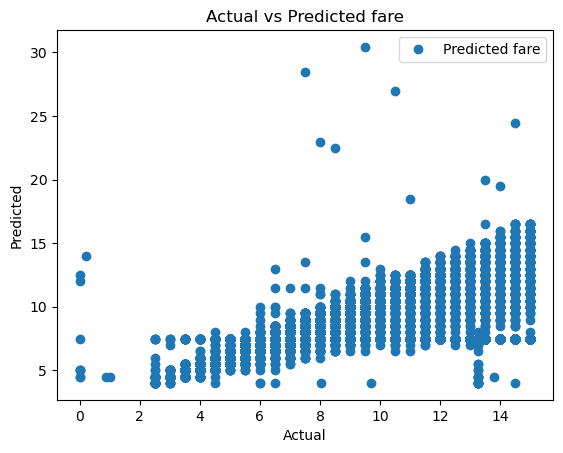

In [54]:
# Creating a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

data.plot(x = 'Actual fare', y='Predicted fare',style='o')
plt.title('Actual vs Predicted fare')  
plt.xlabel('Actual')  
plt.ylabel('Predicted')  
plt.show()

It can be inferred that the model works accurately, but - as previously stated - its range of inaccuracy is too high to be relied upon. This confirms my conclusions when analysing the MSE and the R2 score.

Bias: I consider there is - if at all - little risk of bias in this model test and hypothesis. Both referring to the data collection, and to the actual testing (since it is following the same logical reasoning expounded in the previous notebooks).

Exporting file to folder. Creating and saving new variables in original data set.

In [55]:
df.loc[df['time trip'] < 0]

,VendorID,pickup_date,pickup_time,dropoff_date,dropoff_time,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,dropoff_date_new,geometry,Borough_name,payment_category,pickup hour,pickup time,dropoff time,time trip,pickup,dropoff
1686,2,10/03/2016 00:00,07:19:00,11/03/2016 00:00,07:10:00,6,2.30,-73.986877,40.766460,1,...,2016-03-11,POINT (-73.98687744 40.76646042),Manhattan,Card,7,19,10,-9,19,10
1794,2,10/03/2016 00:00,07:20:00,11/03/2016 00:00,00:00:00,3,0.86,-73.986481,40.768490,1,...,2016-03-11,POINT (-73.98648071 40.76848984),Manhattan,Card,7,20,0,-20,20,0
3458,2,10/03/2016 00:00,07:33:00,11/03/2016 00:00,00:00:00,2,0.97,-73.951736,40.773666,1,...,2016-03-11,POINT (-73.95173645 40.77366638),Manhattan,Card,7,33,0,-33,33,0
4084,2,10/03/2016 00:00,07:37:00,11/03/2016 00:00,07:24:00,1,2.14,-74.015221,40.709358,1,...,2016-03-11,POINT (-74.01522064 40.70935822),Manhattan,Card,7,37,24,-13,37,24
4199,2,10/03/2016 00:00,07:38:00,10/03/2016 00:00,08:00:00,1,2.31,-73.939613,40.751629,1,...,2016-03-10,POINT (-73.93961334 40.75162888),Queens,Card,7,38,0,-38,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72311,2,10/03/2016 00:00,14:11:00,11/03/2016 00:00,14:03:00,1,0.35,-73.993813,40.751621,1,...,2016-03-11,POINT (-73.99381256 40.75162125),Manhattan,Cash,14,11,3,-8,11,3
73637,2,10/03/2016 00:00,14:22:00,11/03/2016 00:00,14:19:00,1,0.87,-73.954041,40.770580,1,...,2016-03-11,POINT (-73.95404053 40.77058029),Manhattan,Cash,14,22,19,-3,22,19
73653,2,10/03/2016 00:00,14:22:00,11/03/2016 00:00,00:00:00,1,2.68,-73.978867,40.765129,1,...,2016-03-11,POINT (-73.97886658 40.76512909),Manhattan,Cash,14,22,0,-22,22,0
74095,2,10/03/2016 00:00,14:25:00,11/03/2016 00:00,00:00:00,6,0.94,-73.971878,40.794392,1,...,2016-03-11,POINT (-73.97187805 40.79439163),Manhattan,Card,14,25,0,-25,25,0


In [56]:
# Replacing  negative outliers with the mean. 
df.loc[df['time trip'] < 0, 'time trip'] = np.nan

In [57]:
# Negative outliers solved => same operation repeated for all columns just named above.
df['time trip'].fillna((df['time trip'].median()), inplace=True)

In [58]:
df['time trip'].describe()

count    74551.000000
mean         9.210125
std          4.595512
min          0.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         58.000000
Name: time trip, dtype: float64

In [59]:
# Exporting 'df' to csv
df.to_csv(os.path.join(path, '2-Data','Prepared Data', 'uber_usd15_timetrips.csv'), index=False)